In [1]:
from writers import foyer_xml_writer
from writers.foyer_xml_writer import parmed_to_foyer_xml, mbuild_to_foyer_xml


import ele
import espaloma as esp
import forcefield_utilities as ffutils
import foyer
import gmso
import mbuild as mb
from mbuild.lib.recipes import Polymer
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield
import numpy as np
from openff.toolkit.topology import Molecule
import torch
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield
import hoomd
import gsd.hoomd
import matplotlib.pyplot as plt

import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

if not os.path.exists("espaloma_model.pt"):
    os.system("wget http://data.wangyq.net/espaloma_model.pt")

/home/madilyn/miniconda3/envs/esp/lib/python3.10/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/home/madilyn/miniconda3/envs/esp/lib/python3.10/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/home/madilyn/miniconda3/envs/esp/lib/python3.10/site-packages/qcelemental/models/results.py:788: DeprecationWarning: ResultProtocols has been renamed to AtomicResultProtocols and will be removed as soon as v0.13.0
  warn(
/home/madilyn/miniconda3/envs/esp/lib/python3.10/site-packages/qcelemental/models/results.py:788: DeprecationWarning: ResultProtocols has been renamed to AtomicResultProtocols and will be removed as soon as v0.13.0
  warn

In [2]:
import mbuild as mb
from openff.toolkit.topology import Molecule
import random
import numpy
import random
import warnings
warnings.filterwarnings("ignore")

octet = {        6 : 4, 7 : 3,1 : 1,8 : 2,16 : 2}
atom_type = {6:"C",7:"N",8:"O",1:"H",16:"S"}

class MadAtom():
    
    def check_happy(self):
        if self.desired_order == self.current_order:
            self.happy = True
            return
        self.happy= False
    
    def add_order(self,o):
        self.current_order += o
        self.check_happy()
        for b in self.bonds:
            b.check_done()
    
    def status(self):
        return self.desired_order - self.current_order
    
    def __str__(self):
        return "{}{}: {}-{}, {}".format(atom_type[self.atomic_number],self.index,self.desired_order,self.current_order,self.happy)
    
    def __init__(self, i, an, do, co ):
        self.index = i
        self.atomic_number = an
        self.desired_order = do 
        self.current_order = co
        self.happy = False
        self.check_happy()
        self.bonds = []

class MadBond():
    def __init__(self,a1,a2,bo,i):
        self.atom1 = a1
        self.atom2 = a2
        self.order = bo
        self.happy = False
        self.index = i
        
    def __repr__(self):
        return "Bond {} {}{}-{}{} O={}, {}. ".format(self.index,atom_type[self.atom1.atomic_number],self.atom1.index,atom_type[self.atom2.atomic_number],self.atom2.index,self.order,self.happy)
    
    def check_done(self):
        if self.atom1.atomic_number == 1:
            self.happy = True
            return
        if self.atom2.atomic_number == 1:
            self.happy = True
            return
        if self.atom1.happy and self.atom2.happy:
            self.happy = True
            return
        self.happy = False
    
    def add_order(self,o):
        self.order += o
        self.atom1.add_order(o)
        self.atom2.add_order(o)
        self.check_done()
        
class BondWalker():

    def __init__(self, mol):
        self.mol = mol
        self.atom_list = []
        for atom in mol.atoms:
            self.atom_list.append(MadAtom(atom.molecule_atom_index, atom.atomic_number, octet[atom.atomic_number], len([b for b in mol.bonds if atom.molecule_atom_index in [b.atom1_index,b.atom2_index]]) )) #assumes we have no double bonds at the start
        self.bond_list = [MadBond(self.atom_list[b.atom1_index],self.atom_list[b.atom2_index],b.bond_order,i) for i,b in enumerate(mol.bonds)] # .bond_order inside each of these, and can use atom1_index atom2_index
        for b in self.bond_list: 
            b.atom1.bonds.append(b)
            b.atom2.bonds.append(b)
            b.check_done()
            
    def done(self):
        for i in self.atom_list:
            if i.happy == False:
                return False
        for i in self.bond_list:
            if i.happy == False:
                return False
        return True
    
    def bond_increasable(self, b):
        if not b.atom1.happy and not b.atom2.happy:
            if b.atom1.status() > 0:
                if b.atom2.status() >0:
                    b.add_order(1) #this triggers each atom to increment, and *their* bonds to check happiness
                    if self.done():
                        return True
                    for a in self.atom_list:
                        if a.happy == False:
                            for bx in a.bonds:
                                if self.bond_increasable(bx):
                                    return True
                            #no bonds around this unhappy atom "a" are increasable
                            b.add_order(-1)
                            return False
                        
    def fill_in_bonds(self):        
        for a in self.atom_list: #since some of the unhappy bonds might end up being OK, let's iterate atoms
            if a.happy == False:
                for b in a.bonds: #try incrementing every bond around every unhappy atom
                    if self.bond_increasable(b):
                        print("Done!")
                        for b1,b2 in zip(self.bond_list, self.mol.bonds):
                            b2.bond_order=b1.order 
                        return self.mol
        print("Sorry- I couldn't solve this")

Done!


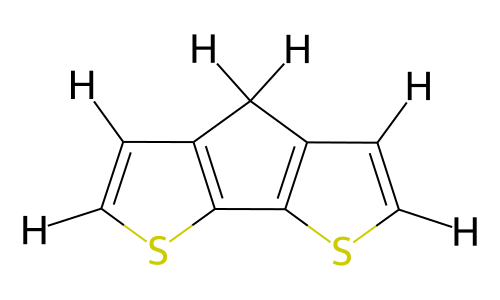

In [4]:
b= BondWalker(Molecule.from_file("/home/madilyn/Projects/repos/forcefields/CPDT.sdf",file_format = "sdf"))
compound = b.fill_in_bonds()
compound.visualize()

In [5]:
#Change input file for molecule
#This one needs to be .sdf file!

molecule = compound

molecule_graph = esp.Graph(molecule)

espaloma_model = torch.load("espaloma_model.pt")
espaloma_model(molecule_graph.heterograph)
openmm_system = esp.graphs.deploy.openmm_system_from_graph(molecule_graph)

# Store the results for each in something more accessible
pair_forces = openmm_system.getForces()[1]
angle_forces = openmm_system.getForces()[3]
bond_forces = openmm_system.getForces()[2]
torsion_forces = openmm_system.getForces()[0]

In [27]:
# get a parmed structure from openmm 
import parmed as pmd
topology = molecule.to_topology()
openmm_topology = topology.to_openmm()

structure = pmd.openmm.load_topology(topology=openmm_topology, system=openmm_system)
structure.bonds.sort(key=lambda x: x.atom1.idx)

In [28]:
# step 1: how to get bond parameters

bond_parameters = {}

for bond in structure.bonds:
    bond_parameters[(bond.atom1.name, bond.atom2.name)] = {"k":[bond.type.k] , "l0":[bond.type.req]}
    
# step 2: get angle parameters

angle_parameters = {}

for angle in structure.angles:
    angle_parameters[(angle.atom1.name, angle.atom2.name,angle.atom3.name)] = {"k":[angle.type.k], 
                                                                               "t0":[angle.type.theteq]}
    
# step 3: dihedral parameters

dihedral_parameters = {}

for dihedral in structure.dihedrals:
    dihedral_parameters[(dihedral.atom1.name, dihedral.atom2.name,dihedral.atom3.name,
                         dihedral.atom4.name)] = {"periodicity":[dihedral.type.per],
                                                  "k":[dihedral.type.phi_k],"phase":[dihedral.type.phase]}
    
# step 4: non-bonding parameters

nonbonded_parameters = {}

for nonbonded in structure.adjusts:
    nonbonded_parameters[(nonbonded.atom1.name,nonbonded.atom2.name)] = {"sigma":[nonbonded.type.rmin],
                                                    "epsilon":[nonbonded.type.epsilon],
                                                    "charge":[nonbonded.type.chgscale]}

In [114]:
for i in range(len(compound.atoms)):
    if compound.atoms[i].atomic_number == 6:
        compound.atoms[i].name = 'C'
    if compound.atoms[i].atomic_number == 1:
        compound.atoms[i].name = 'H'
    if compound.atoms[i].atomic_number == 7:
        compound.atoms[i].name = 'N'
    if compound.atoms[i].atomic_number == 16:
        compound.atoms[i].name = 'S'
    if compound.atoms[i].atomic_number == 8:
        compound.atoms[i].name = 'O'
    #print(compound.atoms[i].name)

In [103]:
particle_types = []
type_map = dict()

for i in range(pair_forces.getNumParticles()):
    pair_parms = pair_forces.getParticleParameters(index=i)
    charge = pair_parms[0]
    sigma = pair_parms[1]
    epsilon = pair_parms[2]
    if (charge, sigma, epsilon) not in particle_types: 
        particle_types.append((charge, sigma, epsilon))

    type_map[compound.atoms[i].molecule_atom_index] = "".join([compound.atoms[i].name , str(particle_types.index((charge, sigma, epsilon)))])

print(type_map)

{0: 'C0', 1: 'C1', 2: 'C2', 3: 'S3', 4: 'C4', 5: 'C5', 6: 'C2', 7: 'C1', 8: 'C5', 9: 'C4', 10: 'S3', 11: 'H6', 12: 'H6', 13: 'H7', 14: 'H8', 15: 'H8', 16: 'H7'}


In [32]:
#""" type map is where our error is coming from """
#
#
#import networkx  as nx
#Gopenmm = nx.Graph()
#Gparmed = nx.Graph()
##openmm:
#for i in range(bond_forces.getNumBonds()):
#    Gopenmm.add_edge(bond_forces.getBondParameters(index=i)[0],bond_forces.getBondParameters(index=i)[1])
##parmed
#for b in structure.bonds:
#    Gparmed.add_edge(b.atom1.idx,b.atom2.idx)
#type_map = {}
##nx.rooted_tree_isomorphism
##in here we still need to check that one known index on one corresponds to the same index on the other....
#tree_openmm = nx.bfs_tree(Gopenmm,0)
#tree_parmed = nx.bfs_tree(Gparmed,0)
#if nx.is_isomorphic(Gopenmm,Gparmed):
##if nx.isomorphism.tree_isomorphism(tree_openmm,tree_parmed):  <- want this work
#    for b in structure.bonds:
#        type_map[b.atom1.idx] = b.atom1.atom_type.__str__()
#        type_map[b.atom2.idx] = b.atom2.atom_type.__str__()
#print(type_map)

{1: 'C2', 0: 'C1', 5: 'C2', 2: 'C2', 3: 'S1', 4: 'C2', 6: 'C2', 10: 'S1', 7: 'C2', 8: 'C2', 9: 'C2', 11: 'H1', 12: 'H1', 13: 'H2', 14: 'H3', 15: 'H3', 16: 'H2'}


In [105]:
# Rename the particle types so that they match the xml file
# This is needed when we aren't using SMARTS matching with Foyer.

CPDT = mb.load("/home/madilyn/Projects/repos/forcefields/CPDT.mol2")

for index in type_map:
    CPDT[index].name = type_map[index]

In [106]:
bond_types = []
bond_dict = dict() 

for i in range(bond_forces.getNumBonds()):
    bond_parms = bond_forces.getBondParameters(index=i)
    l0 = bond_parms[2]/bond_parms[2].unit
    k = bond_parms[3]/bond_parms[3].unit
    bond_dict[type_map[bond_parms[0]],type_map[bond_parms[1]]] = {'k':k,'l0':l0}
print(bond_dict)

{('C0', 'C1'): {'k': 62091.073771214, 'l0': 0.16370454794869382}, ('C0', 'H6'): {'k': 89975.28480830675, 'l0': 0.12312252469607743}, ('C1', 'C2'): {'k': 95343.41173604075, 'l0': 0.14504711691383798}, ('C1', 'C5'): {'k': 62916.00285306054, 'l0': 0.15603395224722857}, ('C2', 'S3'): {'k': 14838.714944712952, 'l0': 0.20129187741816149}, ('C2', 'C2'): {'k': 119899.52420781607, 'l0': 0.1431114199881313}, ('S3', 'C4'): {'k': 16832.664956906985, 'l0': 0.2090723255760851}, ('C4', 'C5'): {'k': 88798.90636082878, 'l0': 0.15396539024526562}, ('C4', 'H7'): {'k': 234207.8104130059, 'l0': 0.1035506322053171}, ('C5', 'H8'): {'k': 67288.62086433225, 'l0': 0.12226254158024269}, ('C2', 'C1'): {'k': 95343.43269265257, 'l0': 0.1450471042972701}, ('C5', 'C4'): {'k': 88798.90636082878, 'l0': 0.15396539024526562}, ('C4', 'S3'): {'k': 16832.671942444256, 'l0': 0.20907235080922085}}


In [107]:
angle_types = []
angle_dict = dict()

for i in range(angle_forces.getNumAngles()):
    angle_parms = angle_forces.getAngleParameters(index=i)
    k = angle_parms[4]/angle_parms[4].unit
    t0 = angle_parms[3]/angle_parms[3].unit  
    angle_dict[type_map[angle_parms[0]],type_map[angle_parms[1]],type_map[angle_parms[2]]] = {'k':k,'t0':t0}
print(angle_dict)

{('C0', 'C1', 'C2'): {'k': 379.10931710139346, 't0': 2.177652597427368}, ('C0', 'C1', 'C5'): {'k': 428.2724833480933, 't0': 2.2276835441589355}, ('C1', 'C0', 'C1'): {'k': 615.1941644468548, 't0': 2.1875996589660645}, ('C1', 'C0', 'H6'): {'k': 542.7076692271827, 't0': 2.2062010765075684}, ('C1', 'C2', 'S3'): {'k': 470.7665094117085, 't0': 2.2712974548339844}, ('C1', 'C2', 'C2'): {'k': 471.8351930978462, 't0': 2.4441423416137695}, ('C1', 'C5', 'C4'): {'k': 538.6140739418067, 't0': 2.1330296993255615}, ('C1', 'C5', 'H8'): {'k': 569.5446342322249, 't0': 2.1879079341888428}, ('C2', 'C1', 'C5'): {'k': 422.1543122802479, 't0': 2.240173578262329}, ('C2', 'S3', 'C4'): {'k': 433.8851070959699, 't0': 1.7351200580596924}, ('C2', 'C2', 'C1'): {'k': 471.83527134383286, 't0': 2.4441423416137695}, ('C2', 'C2', 'S3'): {'k': 408.8791764253329, 't0': 2.442430019378662}, ('S3', 'C2', 'C2'): {'k': 408.8790981793462, 't0': 2.442430257797241}, ('S3', 'C4', 'C5'): {'k': 489.7426478564602, 't0': 2.285471916198

In [108]:
dihedral_types = []
dihedral_dict = {}

for i in range(torsion_forces.getNumTorsions()):
    if i%6==0:
        periodicity=[]
        phase = []
        k = []
    dihedral_parms = torsion_forces.getTorsionParameters(index=i)
    periodicity.append(dihedral_parms[4])  
    phase.append( dihedral_parms[5]/dihedral_parms[5].unit)
    k.append(dihedral_parms[6]/dihedral_parms[6].unit)
    dt = (type_map[dihedral_parms[0]],type_map[dihedral_parms[1]],type_map[dihedral_parms[2]],
                  type_map[dihedral_parms[3]])
   

    if periodicity[-1]==6:
        #print(dt,periodicity,phase)
        dihedral_dict[dt] = {'periodicity':periodicity,'k':k,'phase':phase}
print(dihedral_dict)

{('C0', 'C1', 'C2', 'S3'): {'periodicity': [1, 2, 3, 4, 5, 6], 'k': [3.3956313034013226, 5.358254603319817, 0.3513929454520035, 0.5797049538492011, 2.1823392531222683, 0.10450240559139175], 'phase': [0.0, 3.141592653589793, 3.141592653589793, 0.0, 0.0, 3.141592653589793]}, ('C0', 'C1', 'C2', 'C2'): {'periodicity': [1, 2, 3, 4, 5, 6], 'k': [0.2079778326075487, 5.989132432460718, 0.16017931549162082, 0.6180063643312911, 1.1644274315945493, 0.3958672307273797], 'phase': [0.0, 3.141592653589793, 3.141592653589793, 0.0, 0.0, 3.141592653589793]}, ('C0', 'C1', 'C5', 'C4'): {'periodicity': [1, 2, 3, 4, 5, 6], 'k': [0.13421387384776784, 2.7680874868493093, 0.09594914117193627, 0.9558334118418598, 0.9807645393492262, 0.10474325651915516], 'phase': [0.0, 3.141592653589793, 3.141592653589793, 0.0, 3.141592653589793, 3.141592653589793]}, ('C0', 'C1', 'C5', 'H8'): {'periodicity': [1, 2, 3, 4, 5, 6], 'k': [0.09253321481573865, 3.5598097223686493, 0.2732154240057969, 0.6732675924272584, 0.558236211252

In [109]:
nonbonded_types = []
nonbonded_dict = {}

for i in range(pair_forces.getNumParticles()):
    nonbonded_parms = pair_forces.getParticleParameters(index=i)
    charge = nonbonded_parms[0]/nonbonded_parms[0].unit
    sigma = nonbonded_parms[1]/nonbonded_parms[1].unit
    epsilon = nonbonded_parms[2]/nonbonded_parms[2].unit
    #if (charge,sigma,epsilon) not in nonbonded_types:
    nonbonded_types.append((charge,sigma,epsilon))
    nonbonded_dict[(type_map[i])]={'charge':charge,'sigma':sigma,'epsilon':epsilon}
print(nonbonded_dict)

{'C0': {'charge': 0.05519999999999999, 'sigma': 0.3399669508423535, 'epsilon': 0.4577296}, 'C1': {'charge': -0.1303, 'sigma': 0.3399669508423535, 'epsilon': 0.359824}, 'C2': {'charge': -0.07610000000000001, 'sigma': 0.3399669508423535, 'epsilon': 0.359824}, 'S3': {'charge': 0.09019999999999999, 'sigma': 0.35635948725613575, 'epsilon': 1.046}, 'C4': {'charge': -0.1911, 'sigma': 0.3399669508423535, 'epsilon': 0.359824}, 'C5': {'charge': -0.12100000000000001, 'sigma': 0.3399669508423535, 'epsilon': 0.359824}, 'H6': {'charge': 0.07569999999999999, 'sigma': 0.2649532787749369, 'epsilon': 0.06568879999999999}, 'H7': {'charge': 0.17, 'sigma': 0.2510552587719476, 'epsilon': 0.06276}, 'H8': {'charge': 0.155, 'sigma': 0.25996424595335105, 'epsilon': 0.06276}}


In [112]:
# Save the forcefield XML file for future use, so that we don't have to repeat the espaloma process everytime
mbuild_to_foyer_xml(
    file_name="CPDT.xml", #change this to whatever you want to save your xml file as
    compound=CPDT,
    bond_params=bond_dict,
    angle_params=angle_dict,
    dihedral_params=dihedral_dict,
    dihedral_type="periodic",
    non_bonded_params=nonbonded_dict,
    combining_rule="geometric",
    name="",
    version="",
    coulomb14scale=1.0,
    lj14scale=1.0)

# Save the mb.Compound with the new atom type names for future use.
CPDT.save("/home/madilyn/Projects/repos/forcefields/CPDT_typed.mol2", overwrite=True) #change this to match your molecule name. 